In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import time
from scipy.stats import poisson, chisquare

In [4]:
def calculate_RSI(data, window=14):
    # 計算每日收益
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    # 計算平均收益和平均損失
    avg_gain = gain.rolling(window=window, min_periods=1).mean() #min_periods: 計算所需的最小期間
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss # 計算RS
    rsi = 100 - (100 / (1 + rs)) # 計算RSI

    return rsi

In [5]:
def poisson_1 (data):
    rsi = data["RSI"].to_list()
    delta = data["Close"].diff().to_list()
    b, s = 0, 0
    cb, cs = [], [] #c of overbought, c of oversold.
    x = 0
    for i in range(1, len(rsi)):
        if rsi[i-1] >= 70:
            #x = 1
            if delta[i] > 0: b += 1
            elif (delta[i] < 0 and b != 0) or (delta[i]<0 and b == 0 and x == 0):
                cb.append(b)
                b, x = 0, 0
            elif delta[i] < 0 and b == 0 and x == 1: pass
            x = 1
        elif rsi[i-1] <= 30:
            #x = 2
            if delta[i] < 0: s += 1
            elif (delta[i] > 0 and s != 0) or (delta[i]>0 and s == 0 and x == 0):
                cs.append(s)
                s, x = 0, 0
            elif delta[i] > 0 and s == 0 and x == 2: pass
            x = 2
        else:
            if x == 1 and b != 0:
                cb.append(b)
                b, x = 0, 0
            elif x == 2 and s != 0:
                cs.append(s)
                s, x = 0, 0
            else:
                pass
    return cb, cs

In [25]:
def poisson_2 (data):
    rsi = data["RSI"].to_list()
    delta = data["Close"].diff().to_list()
    price = data["Close"].to_list()
    #b, s = 0, 0
    cb, cs = [], [] #c of overbought, c of oversold.
    pct_b, pct_s = 0, 0 #變動百分比
    x = 0
    t = 50
    for i in range(1, len(rsi)):
        if rsi[i-1] >= 70:
            #x = 1
            if delta[i] > 0: pct_b += abs(delta[i]/price[i-1])
            elif (delta[i] < 0 and pct_b != 0) or (delta[i]<0 and pct_b == 0 and x == 0):
                cb.append(round(pct_b*t))
                pct_b, x = 0, 0
            elif delta[i] < 0 and pct_b == 0: pass
            x = 1
        elif rsi[i-1] <= 30:
            #x = 2
            if delta[i] < 0: pct_s += abs(delta[i]/price[i-1])
            elif (delta[i] < 0 and pct_s != 0) or (delta[i]<0 and pct_s == 0 and x == 0):
                cs.append(round(pct_s*t))
                pct_s, x = 0, 0
            elif delta[i] < 0 and pct_s == 0: pass
            x = 2
        else:
            if x == 1 and pct_b != 0:
                cb.append(round(pct_b*t))
                pct_b, x = 0, 0
            elif x == 2 and pct_s != 0:
                cs.append(round(pct_s*t))
                pct_s, x = 0, 0
            else:
                pass
    return cb, cs

In [7]:
def chisquare_test(x, Lambda):
    adj = []
    for i in x:
        if i not in adj: adj.append(i)
    adj.sort()
    counts = [0]*(adj[-1]+1)
    for i in x: counts[i] += 1
    #print(counts)

    observed_frequencies, lambda_poisson = counts, Lambda
    expected_frequencies = np.array([poisson.pmf(k, lambda_poisson) * sum(observed_frequencies) for k in range(len(observed_frequencies))])
    expected_frequencies *= np.sum(observed_frequencies) / np.sum(expected_frequencies)
    chi2_stat, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies, ddof = len(adj)-2)
    #print(chi2_stat, p_value)
    return round(p_value, 3)

In [8]:
def results (symbol="5274.two", start="2023-01-01", end="2024-01-01"):
    data = yf.download(symbol, start, end)
    data['RSI'] = calculate_RSI(data, window=14)
    cb1, cs1 = poisson_1(data)
    lambda_b1, lambda_s1 = sum(cb1)/len(cb1), sum(cs1)/len(cs1)
    cb2, cs2 = poisson_2(data)
    lambda_b2, lambda_s2 = sum(cb2)/len(cb2), sum(cs2)/len(cs2)
    print(symbol)
    print("assumption 1:")
    print("overbought: ", chisquare_test(cb1, lambda_b1), "oversold: ", chisquare_test(cs1, lambda_s1))
    print("assumption 2:")
    print("overbought: ", chisquare_test(cb2, lambda_b2), "oversold: ", chisquare_test(cs2, lambda_s2))
    return

### Example

In [9]:
symbol = '5274.two'
data = yf.download(symbol, start='2020-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [10]:
data['RSI'] = calculate_RSI(data, window=14)

In [11]:
data['RSI'] 

Date
2020-01-02          NaN
2020-01-03     0.000000
2020-01-06     0.000000
2020-01-07    28.571446
2020-01-08    23.188424
                ...    
2023-12-25    71.739130
2023-12-26    72.142857
2023-12-27    68.032787
2023-12-28    62.406015
2023-12-29    56.896552
Name: RSI, Length: 973, dtype: float64

1.565217391304348


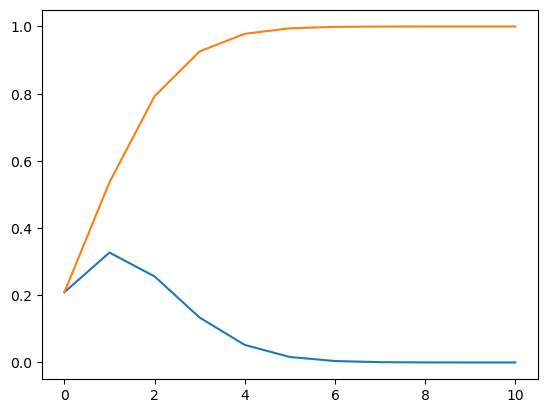

In [12]:
cb = poisson_1(data)[0]
lambda_b = sum(cb)/len(cb) #estimated lambda
print(lambda_b)
plt.plot([i for i in range(0, 11)], [poisson.pmf(i, lambda_b) for i in range(0, 11)])
plt.plot([i for i in range(0, 11)], [poisson.cdf(i, lambda_b) for i in range(0, 11)])
plt.show()

1.0909090909090908


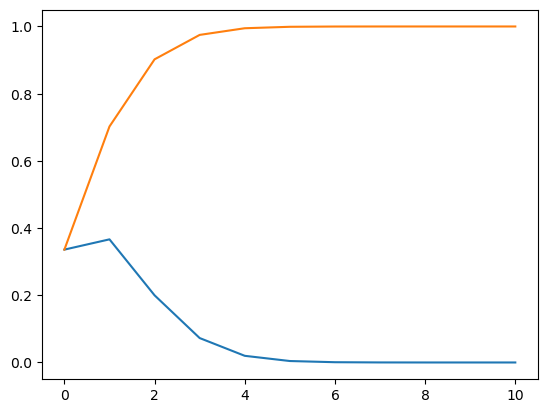

In [13]:
cs = poisson_1(data)[1]
lambda_s = sum(cs)/len(cs) #estimated lambda
print(lambda_s)
plt.plot([i for i in range(0, 11)], [poisson.pmf(i, lambda_s) for i in range(0, 11)])
plt.plot([i for i in range(0, 11)], [poisson.cdf(i, lambda_s) for i in range(0, 11)])
plt.show()

In [14]:
chisquare_test(cb, lambda_b), chisquare_test(cs, lambda_s)

(0.022, 0.001)

In [15]:
cb, cs = poisson_2(data)

2.2


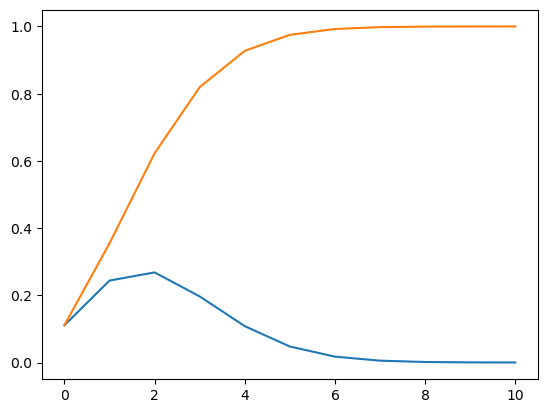

In [16]:
lambda_b = sum(cb)/len(cb) #estimated lambda
print(lambda_b)
plt.plot([i for i in range(0, 11)], [poisson.pmf(i, lambda_b) for i in range(0, 11)])
plt.plot([i for i in range(0, 11)], [poisson.cdf(i, lambda_b) for i in range(0, 11)])
plt.show()

2.857142857142857


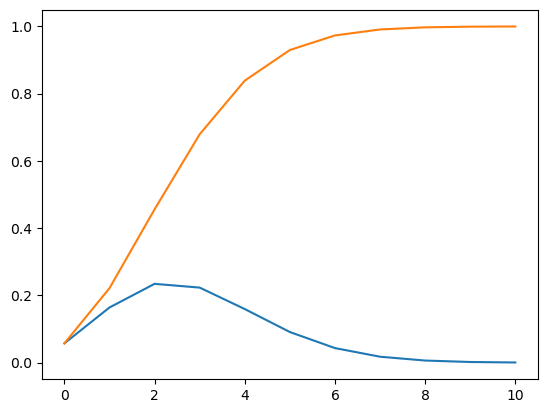

In [17]:
lambda_s = sum(cs)/len(cs) #estimated lambda
print(lambda_s)
plt.plot([i for i in range(0, 11)], [poisson.pmf(i, lambda_s) for i in range(0, 11)])
plt.plot([i for i in range(0, 11)], [poisson.cdf(i, lambda_s) for i in range(0, 11)])
plt.show()

In [18]:
chisquare_test(cb, lambda_b), chisquare_test(cs, lambda_s)

(0.0, 0.005)

### 上市、上櫃基準: 發行日早於2023/01/01

### 1. 上市ETF、市值前5名

In [23]:
symbol_list = ["0050.tw", "0056.tw", "00878.tw", "00919.tw", "006208.tw"]
for i in symbol_list:
    results(symbol=i)

[*********************100%%**********************]  1 of 1 completed
0050.tw
assumption 1:
overbought:  0.114 oversold:  0.346
assumption 2:
overbought:  0.052 oversold:  0.564
[*********************100%%**********************]  1 of 1 completed
0056.tw
assumption 1:
overbought:  0.0 oversold:  0.346
assumption 2:
overbought:  0.0 oversold:  0.756
[*********************100%%**********************]  1 of 1 completed
00878.tw
assumption 1:
overbought:  0.003 oversold:  0.682
assumption 2:
overbought:  0.0 oversold:  0.607
[*********************100%%**********************]  1 of 1 completed
00919.tw
assumption 1:
overbought:  0.0 oversold:  0.48
assumption 2:
overbought:  0.0 oversold:  0.617
[*********************100%%**********************]  1 of 1 completed
006208.tw
assumption 1:
overbought:  0.083 oversold:  0.379
assumption 2:
overbought:  0.052 oversold:  0.564


### 2. 上櫃ETF、市值前5名

In [24]:
symbol_list = ["00679b.two", "00687b.two", "00751b.two", "00720b.two", "00772b.two"]
for i in symbol_list:
    results(symbol=i)

[*********************100%%**********************]  1 of 1 completed
00679b.two
assumption 1:
overbought:  0.039 oversold:  0.0
assumption 2:
overbought:  0.001 oversold:  0.0
[*********************100%%**********************]  1 of 1 completed
00687b.two
assumption 1:
overbought:  0.233 oversold:  0.044
assumption 2:
overbought:  0.289 oversold:  0.0
[*********************100%%**********************]  1 of 1 completed
00751b.two
assumption 1:
overbought:  0.039 oversold:  0.002
assumption 2:
overbought:  0.001 oversold:  0.004
[*********************100%%**********************]  1 of 1 completed
00720b.two
assumption 1:
overbought:  0.0 oversold:  0.267
assumption 2:
overbought:  0.0 oversold:  0.064
[*********************100%%**********************]  1 of 1 completed
00772b.two
assumption 1:
overbought:  0.104 oversold:  0.308
assumption 2:
overbought:  0.007 oversold:  0.261


### 3. 加權指數、櫃買指數

In [21]:
symbol_list = ["^TWII", "^TWOII"]
for i in symbol_list:
    results(symbol=i)

[*********************100%%**********************]  1 of 1 completed
^TWII
assumption 1:
overbought:  0.231 oversold:  0.194
assumption 2:
overbought:  0.558 oversold:  1.0
[*********************100%%**********************]  1 of 1 completed
^TWOII
assumption 1:
overbought:  0.0 oversold:  0.489
assumption 2:
overbought:  0.06 oversold:  0.739
